# Proyecto Etapa 1: Predicción de la demanda de bicletas (Regresión Polinomial y Lasso)

## Análisis del Problema
Se desea construir un modelo predictivo que permita determinar la demanda sobre el uso de un sistema de alquiler de bicicletas. Se busca con esto dar soporte para mejorar el servicio y conocer los factores que inciden en la eficiencia del sistema de alquiler y así, fomentar planes de movilidad sostenible que ayden a reducir las emisiones de CO2 que afectan la temperatura del planeta y desequilibran el ciclo natural.

Los objetivos que se desean abordar con esta primera etapa del proyecto son:
- Aplicar técnicas de regresión para construir un modelo predictivo que permita estimar la demanda sobre el uso de un sistema de alquiler de bicicletas siguiendo el ciclo de machine learning.

- Determinar cuáles son los factores que más inciden en la demanda con base en los datos.

## Recolección de datos

Los datos fueron suministrados por el equipo docente de la universidad y adaptados de los datos originales [Rental Bike Sharing Dataset](https://www.kaggle.com/datasets/imakash3011/rental-bike-sharing) de Kaggle.

Los campos (columnas), tipos de dato y descripción con los que se cuentan son:

| **Columna** | **Tipo**   | **Descripción**                                 |
|-------------|------------|-------------------------------------------------|
| season      | categórica | Estación del año (Winter, Spring, Summer, Fall) |
| weekday     | numérico   | Día de la semana (de 0 a 6 con 0 = Lunes y 6 = Domingo)                     |
| weathersit  | categórica | Clima (Clear, Mist, Light Rain, Heavy Rain) |
| temp        | numérico   | Temperatura (°C) |
| atemp       | numérico   | Sensación de temperatura (°C)|
| hum         | numérico   | Humedad (%) |
| windspeed   | numérico   | Velocidad del viento (m/s) |
| cnt         | numérico   | Cantidad de bicicletas rentadas |
| time_of_day | categórica | Parte del día (Morning, Evening, Night) |


### Importación de librerias

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline

Creación del DataFrame original con los datos sin transformar

In [5]:
#Ubicación del dataset
ruta = "Datos_Etapa-1.csv"

#Importación del Data Set
data_raw = pd.read_csv(ruta, sep=',')

Visualicemos los primeros cinco registros del DataFrame

In [6]:
data_raw.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


### Separación de Datos Train-Test
A continuación se realizará la separación de los datos Train y Test utilizando una proporción de 80%-20% respectivamente.

In [ ]:
# Separación de conjuntos de datos Train y Test
Train, Test = train_test_split(data_raw, test_size = 0.2, random_state=77)

## Exploración de los datos

Veamos algunas estadísticas del DataFrame y un resumen de la cantidad de nulos o faltantes por cada campo:

In [ ]:
Train.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,3.010933,15.344629,15.386425,0.626738,12.758343,190.297777
std,2.006685,9.041724,11.319977,0.192786,8.216776,181.715159
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,41.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,143.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


In [ ]:
print(Train.isna().sum(), '\n')
print(Train.isnull().sum())

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64 

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64


Como se puede observar en el resumen anterior, no existe ningun faltante en los datos, sin embargo es importante verificar duplicados.

In [ ]:
Train.duplicated().sum()

25

Solo existen 25 duplicados de 13903 registros, por lo que podemos eliminar esos duplicados en la etapa de **limpieza y preparación** ya que representan tan solo el 0.18% de los datos. En principio se puede pensar que podemos dejar estos datos y no afectarían al modelo, sin embargo, se eliminarán con el fin de suprimir cualquier posibilidad de sesgo en el modelo final.

### Histogramas para cada campo

Resulta útil visualizar los histogramas para cada campo con el fin de analizar sus distribuciones y posibles outlayers:

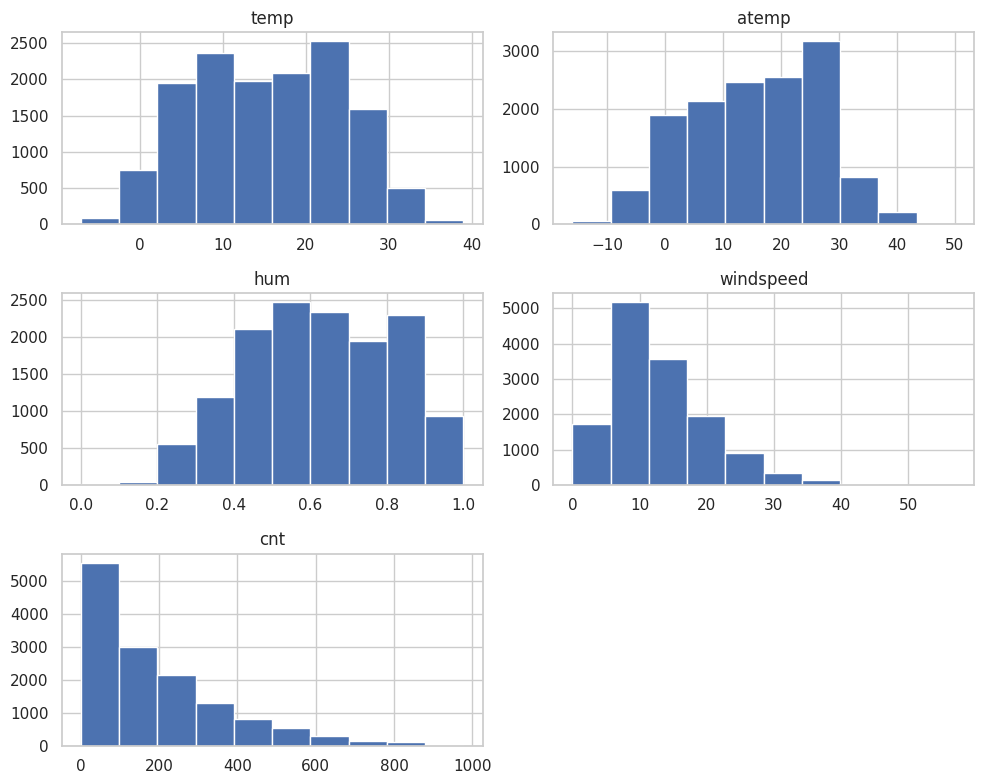

In [ ]:
# Creación de dataframe sin campo weekday
data_to_plot = Train.drop(columns=['weekday'])

# Creación de histogramas para cada campo no categórico
data_to_plot.hist(figsize=(10, 8))
plt.tight_layout()  # Ajustando el espaciado entre los subplots para que no se solapen
plt.show()


Aunque existen algunos valores extremos (posibles outlayers) para la temperatura, la sensación térmica, la humedad, la velocidad del viento y la cantidad de bicicletas prestadas, es muy probable que estos datos no sean errores, sino condiciones reales que se presentan durante las diferentes temporadas de alquiler debido a los cambios estacionales. Por lo anterior, no eliminaremos esos datos y construiremos el modelo de regresión teniendolos en cuenta.

Por otro lado, las variables categóricas (incluyendo la del día de la semana *weekday*) deben ser visualizadas con graficos de barras ya que los hisogramas son para variables numéricas.

A continuación, las distribuciones para las variables categóricas: *season*, *weekday*, *weathersit* y *time_of_day*.

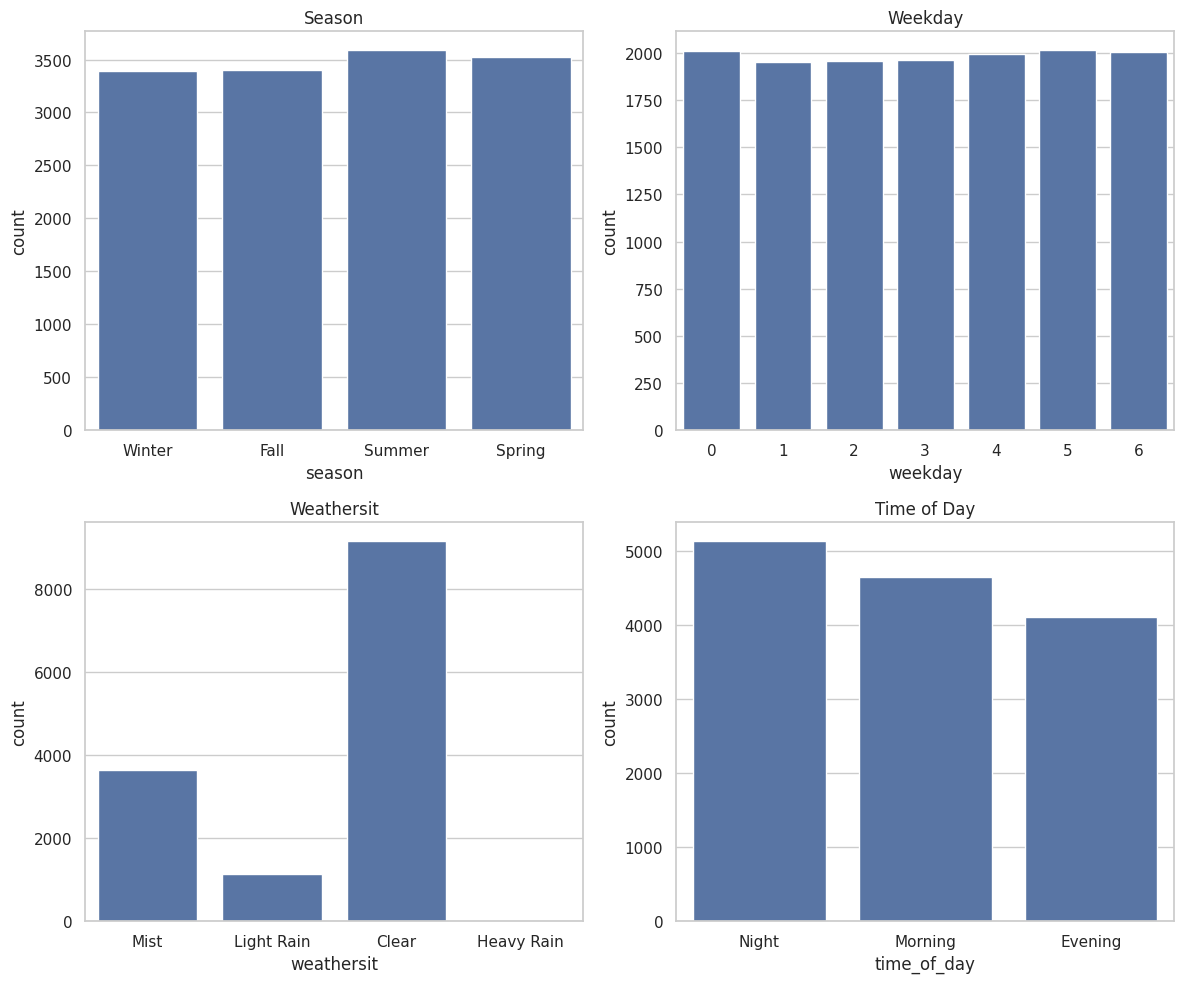

In [ ]:
# Configuración de los estilos de Seaborn
sns.set(style="whitegrid")

# Crear subplots para cada variable categórica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Histograma para la variable 'season'
sns.countplot(x='season', data=Train, ax=axes[0, 0])
axes[0, 0].set_title('Season')

# Histograma para la variable 'weekday'
sns.countplot(x='weekday', data=Train, ax=axes[0, 1])
axes[0, 1].set_title('Weekday')

# Histograma para la variable 'weathersit'
sns.countplot(x='weathersit', data=Train, ax=axes[1, 0])
axes[1, 0].set_title('Weathersit')

# Histograma para la variable 'time_of_day'
sns.countplot(x='time_of_day', data=Train, ax=axes[1, 1])
axes[1, 1].set_title('Time of Day')

plt.tight_layout()
plt.show()


La distribución de weathersit pareciera mostrar muy pocos registros para el estado Heavy Rain. Verificando esto directamente se obtiene que solo existen tres registros con este estado:

In [ ]:
Train[Train['weathersit'] == 'Heavy Rain']

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
585,Winter,3,Heavy Rain,2.34,-2.9980,0.93,22.0028,36,Evening
8854,Winter,1,Heavy Rain,1.40,-0.9982,0.86,6.0032,164,Evening
9123,Winter,6,Heavy Rain,-1.42,-6.9976,0.86,12.9980,23,Night


Observe como la humedad en esos registros con estado *Heavy Rain* es coherente con el campo *weathersit*, lo que nos indica que no son errores sino condiciones reales que se presentaron y quedaron registradas. Por lo anterior, no se eliminarán del dataframe ya que aportan información sobre el comportamiento variable del aquiler de bicicletas bajo esas condiciones extremas.

Veamos entonces si podemos unificar estos registros en la categoría *Light Rain* a partir de la similitud con el resto de variables predictoras.

In [ ]:
# Observando las características de los registros cuyo 'weathersit' == 'Light Rain'
Train[Train['weathersit'] == 'Light Rain'].describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000,1133.000000
mean,3.031774,13.435816,12.776052,0.828138,14.779597,111.207414
std,1.886547,7.563599,9.541044,0.159239,8.728954,133.235638
min,0.000000,-4.240000,-12.997000,0.000000,0.000000,1.000000
25%,2.000000,7.980000,5.001200,0.780000,8.998100,20.000000
50%,3.000000,13.620000,13.997000,0.870000,12.998000,62.000000
75%,5.000000,20.200000,20.003000,0.930000,19.999500,153.000000
max,6.000000,35.240000,42.997400,1.000000,56.996900,891.000000


Como *temp*, *atemp* y *hum* se encuentran dentre del rango de los registros clasificados con *weathersit* igual *Light Rain*, cambiaremos la clasificación de los tres registros clasificados como *Heavy Rain* a *Light Rain*. Esto evitará problemas en el conjunto de datos de Test donde tampoco estará presente la clasificación *Heavy Rain* y que en todos los datos solo existen estos tres registros con esta clasificación.

## Limpieza y preparación

En esta etapa realizaremos las siguientes operaciones:

1. Cambio de clasificación *Heavy Rain* a *Light Rain* para los únicos tres registros con esta clasificación en el campo *weathersit*.
2. Eliminación de duplicados.
3. Creación de dataframes x_train y y_train.
4. Codificación One-Hot para variables categóricas: *season*, *weekday*, *weathersit* y *time_of_day*.
5. Estandarización de variables numéricas originales: *temp*, *atemp*, *hum* y *windspeed*

### Cambio de Heavy Rain a Light Rain

Cambiaremos esta clasificación para los únicos tres registros con este estado en el campo 'weathersit' por las razones que ya se explicaron en la sección ***Exploración de los datos***.

In [ ]:
indices = Train[Train['weathersit'] == 'Heavy Rain'].index
for indice in indices:
    Train.loc[indice, 'weathersit'] = 'Light Rain'
Train[Train['weathersit'] == 'Heavy Rain'].head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day


Como se puede observar ya no existen registros con la clasificación *Heavy Rain*. Veriquemos ahora que los registros originales hayan quedado con la clasificación *Light Rain*.

In [ ]:
for indice in indices:
    print(Train.loc[indice:indice, :])

     season  weekday  weathersit  temp  atemp   hum  windspeed  cnt  \
585  Winter        3  Light Rain  2.34 -2.998  0.93    22.0028   36   

    time_of_day  
585     Evening  
      season  weekday  weathersit  temp   atemp   hum  windspeed  cnt  \
8854  Winter        1  Light Rain   1.4 -0.9982  0.86     6.0032  164   

     time_of_day  
8854     Evening  
      season  weekday  weathersit  temp   atemp   hum  windspeed  cnt  \
9123  Winter        6  Light Rain -1.42 -6.9976  0.86     12.998   23   

     time_of_day  
9123       Night  


### Eliminación de duplicados

In [ ]:
Train = Train.drop_duplicates()
Train.shape

(13878, 9)

Como se puede observar se eliminaron únicamente los 25 duplicados.

### Dataframes x_train y y_train

In [ ]:
x_train = Train.drop('cnt', axis=1)
y_train = Train['cnt']

Verifiquemos que los dataframes anteriores esten construidos correctamente.

In [ ]:
x_train.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,time_of_day
326,Winter,6,Mist,-0.48,-2.9980,0.59,6.0032,Night
694,Winter,2,Light Rain,-0.48,-0.9982,0.93,0.0000,Morning
16787,Fall,5,Mist,5.16,1.9982,0.75,11.0014,Morning
13096,Summer,3,Clear,31.48,36.9980,0.53,8.9981,Night
17193,Winter,1,Clear,0.46,-2.9980,0.80,8.9981,Morning


In [ ]:
y_train.head()

326       12
694       52
16787     84
13096    584
17193      9
Name: cnt, dtype: int64

### Codificación One-Hot para Variables Categóricas

Esta técnica nos permitrá crear variables dummies numéricas para las variables categóricas *season*, *weekday*, *weathersit* y *time_of_day*. Lo anterior es necesario para que el algoritmo de regresión pueda usar estar variables y por tanto tenerlas en cuenta en el ajuste de parámetros.

In [ ]:
# Aplica la codificación one-hot a las variables categóricas
x_train = pd.get_dummies(x_train, columns=['season', 'weekday', 'weathersit', 'time_of_day'])
x_train.head()

,temp,atemp,hum,windspeed,season_Fall,season_Spring,season_Summer,season_Winter,weekday_0,weekday_1,...,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Clear,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
326,-0.48,-2.9980,0.59,6.0032,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
694,-0.48,-0.9982,0.93,0.0000,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
16787,5.16,1.9982,0.75,11.0014,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
13096,31.48,36.9980,0.53,8.9981,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
17193,0.46,-2.9980,0.80,8.9981,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0


Observe como pasamos de tener 8 variables predictoras a 21, lo anterior ocurre porque para cada variable categórica se dan:

* *season*: 4 estaciones.
* *weekday*: 7 días de la semana
* *weathersit*: 3 estados del clima (recordemos que se cambió *Heavy Rain* por *Light Rain*).
* *time_of_day*: 3 momentos del día.

Para un total de 17 nuevas variables predictoras numéricas; estas unidas a las 4 variables numéricas originales (*temp*, *atemp*, *hum* y *windspeed*) dan un total de 21 variables predictoras numéricas.


### Estandarización de Variables Numéricas Originales

Las variables numéricas originales son: *temp*, *atemp*, *hum* y *windspeed*.

Aplicaremos estandarización únicamente a estas variables ya que las variables ficticias creadas en el paso anterior ya se encuentran estandarizadas por ser binarias (0 para ausente y 1 para existente).

Como las variables ficticias son binarias, utilizaremos la estandarización MinMaxScaler para el resto de variables con el fin de que todas las variables predictoras esten en la misma escala de 0 a 1.

Lo anterior se escogió así para no dar de antemano ninguna importancia adicional a alguna variable sobre las demás.

In [ ]:
# Guardamos el nombre de las columnas a procesar originales
columns_num = ['temp',	'atemp',	'hum',	'windspeed']
# Creamos el objeto scaler
scaler = MinMaxScaler()
# Aplicamos el objeto Scaler a las columnas específicadas
x_train_num = scaler.fit_transform(x_train[columns_num])
# Convertirmos a dataframe la salida del escalador con las columnas originales
x_train_num = pd.DataFrame(x_train_num, columns=columns_num)
# Copiamos los indices del dataframe original para evitar problemas en la actualización de x_train
x_train_num = x_train_num.set_index(x_train.index)
# Actualizamos las variables escaladas en el dataframe original
for col in columns_num:
  x_train[col] = x_train_num[col]
# Visualizamos el resultado
x_train.head()

,temp,atemp,hum,windspeed,season_Fall,season_Spring,season_Summer,season_Winter,weekday_0,weekday_1,...,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Clear,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
326,0.142857,0.1970,0.59,0.105325,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
694,0.142857,0.2273,0.93,0.000000,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
16787,0.265306,0.2727,0.75,0.193018,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
13096,0.836735,0.8030,0.53,0.157870,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
17193,0.163265,0.1970,0.80,0.157870,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0


Como se observa, únicamente fueron modicadas las variables numéricas originales *temp*, *atemp*, *hum* y *windspeed*, mientras que las categóricas transformadas siguen siendo binarias.

## Modelado

Construiremos y evaluaremos dos modelos de regresión: Polinomial y Lasso. Para ambos utilizaremos la clase GridSearchCV para encontrar el hiperparámetro más adecuado en ambas regresiones.

Para la regresión polinomial exploraremos los grados (hiperparámetros) [2, 3], mientras que para la regresión Lasso exploraremos los hiperparámetros alpha [1, 2, 3, 4, 5]. En ambos casos usaremos la métrica RMSE.

Por último, usaremos en el entrenamiento la validación cruzada k-flod con k=10 y shuffle=True para indicarle que cambie el orden de los datos antes de separarlos en los grupos.

### Regresión Polinomial

A continuación se exploraran los grados más adecuados por un modelo de regresión polinomial.

#### Busqueda de hiperparámetros

Crearemos un objeto make_pipeline() llamado polynomial_regression que usará la clase PolynomialFeatures() para transformar el conjunto de datos con cada grado explorado, y la clase LinearRegression() que entrenará cada modelo con los hiperparámetros introducidos.

In [ ]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(),
    LinearRegression()
)

Ahora creamos la variable que contendrá los hiperparámetros a evaluar.

In [ ]:
param_grid = {'polynomialfeatures__degree': [2, 3]}

Definimos ahora un objeto KFlod() que nos ayudará a encontrar el mejor desempeño para cada modelo evaluado.

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

Finalmente, realizaremos una búsqueda exhaustiva de hiperparámetros con la función GridSearchCV y usando como atributos los objetos construidos anterioremente:

In [ ]:
modelos_grid = GridSearchCV(polynomial_regression, param_grid, cv=kfold, n_jobs=-1, scoring='neg_root_mean_squared_error')

A continuación entrenamos todos los modelos usando el método fit() con los conjuntos de entrenamiento.

In [ ]:
modelos_grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'polynomialfeatures__degree': [2, 3]},
             scoring='neg_root_mean_squared_error')

#### Selección del mejor modelo

Veamos ahora cuál fue el mejor hiperparámetro:

In [ ]:
print('Mejor hiperparámetro: ', modelos_grid.best_params_)

Mejor hiperparámetro:  {'polynomialfeatures__degree': 3}


Como se puede apreciar, el grado más óptimo para la regresión polinomial es 3.

Seleccionamos ahora el mejor modelo:

In [ ]:
mejor_modelo = modelos_grid.best_estimator_

#### Evaluación

Para esta última parte usaremos el conjunto de datos de evaluación Test. Separaremos estos datos en x_test y y_test, donde ésta última contendrá la variable objetivo 'cnt', mientras que la primera solo contendrá las variables predictoras.

Sin embargo, necesitamos realizar sobre los datos de Test las mismas transformaciones que hicimos a sobres datos de entrenamiento:

In [ ]:
# Separación de datos en variables predictoras y variable objetivo
x_test = Test.drop('cnt', axis=1)
y_test = Test['cnt']

Codificación One-Hot para variables predictoras categóricas:

In [ ]:
# Aplica la codificación one-hot a las variables categóricas
x_test = pd.get_dummies(x_test, columns=['season', 'weekday', 'weathersit', 'time_of_day'])
x_test.head()

,temp,atemp,hum,windspeed,season_Fall,season_Spring,season_Summer,season_Winter,weekday_0,weekday_1,...,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Clear,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
13229,27.72,30.9986,0.62,12.9980,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
15755,23.96,26.0024,0.44,6.0032,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5185,26.78,30.0020,0.66,7.0015,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
15637,18.32,18.9998,0.64,22.0028,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
14484,33.36,34.9982,0.32,11.0014,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0


Ahora, escalemos las variables numéricas original con MinMaxScaler:

In [ ]:
# Aplicamos el objeto Scaler a las columnas específicadas
x_test_num = scaler.transform(x_test[columns_num])
# Convertirmos a dataframe la salida del escalador con las columnas originales
x_test_num = pd.DataFrame(x_test_num, columns=columns_num)
# Copiamos los indices del dataframe original para evitar problemas en la actualización de x_test
x_test_num = x_test_num.set_index(x_test.index)
# Actualizamos las variables escaladas en el dataframe original
for col in columns_num:
  x_test[col] = x_test_num[col]
# Visualizamos el resultado
x_test.head()

,temp,atemp,hum,windspeed,season_Fall,season_Spring,season_Summer,season_Winter,weekday_0,weekday_1,...,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Clear,weathersit_Light Rain,weathersit_Mist,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
13229,0.755102,0.7121,0.62,0.228047,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
15755,0.673469,0.6364,0.44,0.105325,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5185,0.734694,0.6970,0.66,0.122840,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
15637,0.551020,0.5303,0.64,0.386035,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
14484,0.877551,0.7727,0.32,0.193018,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [ ]:
y_pred = mejor_modelo.predict(x_test)

print('------ Modelo de regresión polinomial múltiple----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print('R²: %.2f' % r2_score(y_test, y_pred))

------ Modelo de regresión polinomial múltiple----
RMSE: 128.46
MAE: 93.80
R²: 0.49


Se puede observar como el modelo de regresión polinomial de grado 3 obtiene un error de 128 alquileres (rmse) mientras que el 49% de la variabilidad en el alquiler de bicicletas es explicado por dicho modelo.

### Regresión Lasso

A continuación se explorará la regularización Lasso para este mismo problema con el fin de determinar si es posible obtener una mejor generalización del modelo y también si es posible realizar una selección de variables.

#### Busqueda de hiperparámetros

Para este método de regularización exploraremos los valores [1, 2, 3, 4, 5] para el hiperparámetro alpha.

Primero, definiremos un objeto Lasso():

In [ ]:
lasso = Lasso()

Ahora definiremos los parámetros que se exploran:

In [ ]:
param_grid = {'alpha': [1, 2, 3, 4, 5]}

Utilizaremos el mismo objeto kfold creado anteriormente. A continuación crearemos el objeto GridSearchCV que nos ayudará con la busqueda del mejor hiperparámetro alpha:

In [ ]:
modelos_lasso = GridSearchCV(lasso, param_grid, cv=kfold, n_jobs=-1, scoring='neg_root_mean_squared_error')

Finalmente, entremos los cinco modelos Lasso para poder escoger el mejor:

In [ ]:
modelos_lasso.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

#### Selección del mejor modelo

A continuación, imprimiremos el mejor hiperparámetro encontrado para la regulalización Lasso y luego seleccionamos el mejor modelo con dicho hiperparámetro:

In [ ]:
print('Mejor hiperparámetro: ', modelos_grid.best_params_)

Mejor hiperparámetro:  {'polynomialfeatures__degree': 3}


In [ ]:
mejor_lasso = modelos_lasso.best_estimator_

Ahora, veamos los parámetros ajustados por este modelo a cada unas de las variables predictoras y observemos si con este hiperparámetro existe alguna selección de características:

In [ ]:
list(zip(x_train.columns, mejor_lasso.coef_))

[('temp', 224.6294760561742),
 ('atemp', 26.137996467195848),
 ('hum', -125.35599694610859),
 ('windspeed', -0.0),
 ('season_Fall', 29.95786631220262),
 ('season_Spring', 5.429724929780824),
 ('season_Summer', -0.3293810220424835),
 ('season_Winter', -29.685249802102813),
 ('weekday_0', -1.875586284462299),
 ('weekday_1', -0.0),
 ('weekday_2', -0.0),
 ('weekday_3', 0.0),
 ('weekday_4', 0.0),
 ('weekday_5', 0.0),
 ('weekday_6', 0.0),
 ('weathersit_Clear', 7.7021099266225415),
 ('weathersit_Light Rain', -30.583989825717598),
 ('weathersit_Mist', -0.0),
 ('time_of_day_Evening', 90.82929221684715),
 ('time_of_day_Morning', 0.0),
 ('time_of_day_Night', -100.7531167423375)]

Como se puede observar, existen varios coeficientes igual cero, lo que significa que para este modelo con regularización, hay características que no arrojan información relevante para la predicción.

Las características eliminadas por el modelo fueron:

* ('windspeed', -0.0)
* ('weekday_1', -0.0)
* ('weekday_2', -0.0)
* ('weekday_3', 0.0)
* ('weekday_4', 0.0)
* ('weekday_5', 0.0)
* ('weekday_6', 0.0)
* ('weathersit_Mist', -0.0)
* ('time_of_day_Morning', 0.0)

Mientras que las características conservadas fueron:

* ('temp', 237.76908998934726)
* ('atemp', 4.899896268584946)
* ('hum', -113.30077601672934)
* ('season_Fall', 30.704263857868572)
* ('season_Spring', 2.817102381994962)
* ('season_Summer', -0.5369671128486406)
* ('season_Winter', -31.10201129099117)
* ('weekday_0', -2.3701308862106076)
* ('weathersit_Clear', 7.832606524830858)
* ('weathersit_Light Rain', -34.22893860213138)
* ('time_of_day_Evening', 92.72705130007017)
* ('time_of_day_Night', -101.30352566156154)

#### Evaluación

Finalmente, evaluemos el mejor modelo Lasso cuyo hiperparámetro es 3:

In [ ]:
y_pred = mejor_lasso.predict(x_test)

print('------ Modelo de regresión Lasso----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print('R²: %.2f' % r2_score(y_test, y_pred))

------ Modelo de regresión Lasso----
RMSE: 136.86
MAE: 102.09
R²: 0.42


Se observa una pequeña disminución en la capacidad de generalización del modelo Lasso respecto al modelo polinomial de grado 3.

### Comparación entre el Modelo Polinomial y Lasso

A continuación se presenta una tabla comparativa con las métricas RMSE, MAE y R² para ambos modelos estudiados:

| Métrica | Polinomial (n=3) | Lasso (α=3) |
|---------|------------------|-------------|
| RMSE    |     130.10       |   137.51    |
| MAE     |     93.77        |   101.39    |
| R²      |     0.49         |   0.43      |

Como se puede observar, la regularización empeoró levemente la capacidad de generalización respecto al modelo polinomial de grado 3. Para el RMSE, Lasso es un 5.7% peor que el modelo Polinomíal. Para el MAE, el modelo polinomial es un 7.5% mejor que Lasso. Y para el R², Lasso disminuyó en un 14% la explicabilidad de la variabilidad de las relaciones lineales entre las variables predictoras y la variable objetivo.

### Análisis de Resultados

A continuación, se abordan las respuestas a algunas preguntas de interés sobre el proceso de modelamiento:

**1. ¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?**

Como se observó anteriormente, el grado para la regresión polinomial encontrado con el método exhaustivo GridSearchCV fue 3, lo que significa que por cada variable predictora, se creó una nueva con la potencia cúbica de dicha variable, más los términos cruzados entre cada par de variables.

**2. ¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?**

Como se observó en la última parte, el mejor hiperparámetro encontrado para el coeficiente de regularización Lasso, fue α = 3. Este hiperparámetro hizo que la regularización Lasso seleccionara solo algunas variables como significativas para el modelo final haciendo que algunos coeficientes fueran cero.

**3. A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?**

El mejor modelo obtenido fue la regresión polinomial de grado 3, para la cual se obtuvieron las siguientes métricas:

* RMSE = 128.46: Lo cual significa que el error cuadrático médio es de aproximadamente 128 prestamos de bicicletas.

* MAE = 93.80: Lo cual signicia que el error abosoluto medio es de aproximadamente 94 prestamos de bicicletas.

* R² = 0.49: Lo cual significa que el 49% de la variabilidad sobre la cantidad del alquiler de biciletas, es explicada por el modelo de regresión polinomial de grado 3.

**4. ¿Cuáles variables fueron seleccionadas con el modelo Lasso? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.**

Las variables seleccionadas por el método de regularización Lasso y sus respectivos coeficientes fueron:

| Variable              | Coeficiente |
|-----------------------|-------------|
|'temp'                 |  237.77     |
|'atemp'                |    4.90     |
|'hum'                  | -113.30     |
|'season_Fall'          |   30.70     |
|'season_Spring'        |    2.82     |
|'season_Summer'        |   -0.54     |
|'season_Winter'        |  -31.10     |
|'weekday_0'            |   -2.37     |
|'weathersit_Clear'     |    7.83     |
|'weathersit_Light Rain'|  -34.23     |
|'time_of_day_Evening'  |   92.73     |
|'time_of_day_Night'    | -101.30     |

<font size = 1> *(Los coeficientes fueron aproximados a dos cifras decimales)* </font>

- En las variables anteriores, se observa cómo solo el domingo (weekday = 0) es significativo para el modelo, lo cual puede implicar que:
  - Las demás variables de cada día se parecen tanto entre sí, que el modelo optó por dejar solo una, ó.
  - El domingo, al ser el día con más bicicletas alquiladas, es el día donde se observa una fuerte relación lineal entre día de la semana y cantidad de bicicletas alquiladas.

- Se observa como la variable weathersit_Mist no tiene ponderancia sobre el modelo, es decir, la cantidad de bicicletas prestadas no varía significativamente cuando hay neblina, por lo que la regularización elimina esta variable. Lo mismo ocurre con time_of_day_Morning

- Se puede observar también como existe una fuerte relación lineal entre las variables predictoras temperatura, humedad y time_of_day_Night, y la variable dependiente cnt (cantidad de bicicletas alquiladas). Es decir, que:
  - Al ser positivo el coeficiente de la variable temperatura, a medida que ésta aumenta, también lo hace la cantidad de bicicletas alquiladas. Es decir, las personas prefieren andar en bicicleta cuánto más soleado o caluroso es el clima.
  - Al ser negativos los coeficientes de las variables humedad y time_of_day_Night, a medida que estas aumentan, la cantidad de bicicletas en alquiler disminuye. Es decir, las personas no prefieren andar en bicicleta cuando el ambiente está humedo o es de noche.

- Finalmente, también se observa una relación positiva importante entre la variable time_of_day_Evening y la cantidad de bicicletas alquiladas. Lo anterior puede deberse a que en la tarde las personas salen del trabajo pueden alquilar bicicletas para movilizarse, ó, asociandolo con el valor de temperatura, es en esta parte del día cuando la temperatura es la más alta y las personas prefieren movilizarse en bicicleta como ya se observó anteriormente.
